In [1]:
from astropy.modeling.astro_sherpa import SherpaFitter, _make_datasets, _astropy_to_sherpa_model, DataSimulFit, SimulFitModel, Fit
from astropy.modeling import FittableModel
from collections import defaultdict, OrderedDict
from astropy.modeling.models import Gaussian1D
import numpy as np
%pylab inline
plt.ion()

Populating the interactive namespace from numpy and matplotlib


In [2]:
class tied_para_fitter(SherpaFitter):
     def __call__(self, models, x, y, z=None, xerr=None, yerr=None, zerr=None, tie_list=None, **kwargs):
        """
        Fit the astropy model with a the sherpa fit routines.

        Parameters
        ----------
        models : `~astropy.modeling.FittableModel` or list of `~astropy.modeling.FittableModel` 
            model to fit to x, y, z
        x : array
            input coordinates
        y : array
            input coordinates
        z : array (optional)
            input coordinates
        xerr : array (optional)
            an array of errors in x
        yerr : array (optional)
            an array of errors in y
        zerr : array (optional)
            an array of errors in z
        tie_list: list
            a list with stucture [(targetmodel.par1,tiemodel.par2),...]
        **kwargs:
            keyword arguments will be passed on to sherpa fit routine

        Returns
        -------
        model_copy : `~astropy.modeling.FittableModel` or a list of `~astropy.modeling.FittableModel`
            a copy of the input model with parameters set by the fitter
        """
        def _make_simfit_model(models,tie_list,model_dict):
            '''
            makes a SimulFitModel for the models suplied it also links and parameters within tie_list
            model_dict updated with astropy models and their converted conterparts this is used for 
            repopulating the model later
            '''
            for mod in models:
                model_dict[mod] = _astropy_to_sherpa_model(mod)    
            if tie_list is not None:
                for par1, par2 in tie_list:
                    getattr(model_dict[par1._model], par1.name).link = getattr(model_dict[par2._model], par2.name)
                    
            return SimulFitModel("wrapped_fit_model", model_dict.values())
                
        self._data = _make_datasets(model.n_inputs, x, y, z, xerr, yerr, zerr)
    
        model_dict=OrderedDict()
        
        if isinstance(models,FittableModel):
            models=[models]
        
        if isinstance(self._data, DataSimulFit):
            _ndata = len(self._data.datasets)
            if len(models) == 1:
                self._fitmodel = SimulFitModel("wrapped_fit_model", [_astropy_to_sherpa_model(models[0]) for _ in xrange(_ndata)])
                # Copy the model so each data set has the same model!
            elif len(models)==_ndata:
                self._fitmodel = _make_simfit_model(models, tie_list, model_dict)    
            else:
                raise Exception("Don't know how to handle multiple models unless there is one foreach dataset")
        else:
            if len(models)>1:
                self._data = DataSimulFit("wrapped_data",[self._data for _ in xrange(len(models))])
                self._fitmodel = _make_simfit_model(models, tie_list,model_dict)    
            else:
                self._fitmodel = _astropy_to_sherpa_model(models[0])

        self._fitter = Fit(self._data, self._fitmodel, self._stat_method, self._opt_method, self._est_method, **kwargs)
        self.fit_info = self._fitter.fit()
        
        if isinstance(self._fitmodel, SimulFitModel):
            return_models=[]
            for apymod, shmod in model_dict.items():
                return_models.append(apymod.copy())
                for pname,pval in map(lambda p:(p.name,p.val), shmod.pars):
                    getattr(return_models[-1], pname.split(".")[-1]).value=pval
        else:
            return_models=apymod.copy()
            for pname,pval in map(lambda p:(p.name,p.val),self._fitmodel.pars):
                getattr(return_models, pname.split(".")[-1]).value=pval

        return return_models
        
        
        

Ok so lets define some models and make some data from them

In [3]:
model = (Gaussian1D(amplitude=1.2, mean=0.9, stddev=0.5) +
         Gaussian1D(amplitude=2.0, mean=-0.9, stddev=0.75))

err = 0.05
x = np.arange(-3, 3, .001)
y = []
yerrs = []

y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))

model.mean_0 = 1.0
model.mean_1 = -1
y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))


model.mean_0 = 0.6
model.mean_1 = -0.4
y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))


model.amplitude_1 = 0.2
model.mean_1 = -2
y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))

xx=np.vstack([x for _ in xrange(len(y))])

model.amplitude_0 = 2
model.mean_0 = .5
model.stddev_0 = 0.4
model.amplitude_1 = 1.5
model.mean_1 = -0.4
model.stddev_1 = 0.35

Now we have some data lets first fit the data without tying parameters.
We dont vary amplitude_0 so lets see how it goes.

In [4]:
tpfit=tied_para_fitter()
fitmodel=tpfit([model.copy() for n in xrange(len(y))], xx, y, yerr=yerrs)

lets plot amplitude_0 for each model as a horizontal line we should only see 1

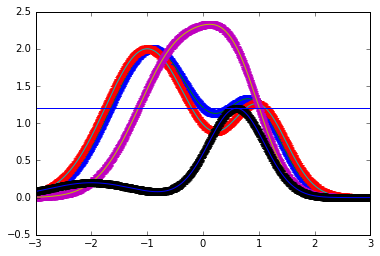

In [5]:
for yy, yee,fm in zip(y, yerrs, fitmodel):
    plt.errorbar(x, yy, yerr=yee,ls='')
    plt.plot(x, fm(x))
    plt.axhline(fm.amplitude_0.value)

ok for such a simple example the fitter works pretty well but lets tie the amplitude_0's anyway

In [6]:
models=[model.rename("gaus%i"%n) for n in xrange(len(y))]
fitmodel=tpfit(models, xx, y, yerr=yerrs, tie_list=[(mod.amplitude_0, models[0].amplitude_0) for mod in models[1:]])

Once again we should only see 1!

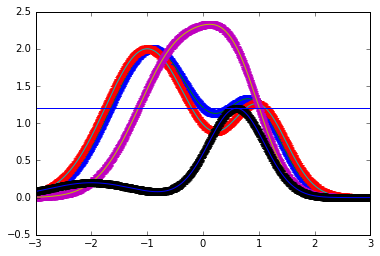

In [7]:
for yy, yee,fm in zip(y, yerrs, fitmodel):
    plt.errorbar(x, yy, yerr=yee,ls='')
    plt.plot(x, fm(x))
    plt.axhline(fm.amplitude_0.value)

It worked but lets print out the fitted model to test and make sure the model did have linked parameters

In [8]:
print tpfit._fitmodel

wrapped_fit_model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   wrap_gaus0.amplitude_0 thawed          1.2 -3.40282e+38  3.40282e+38           
   wrap_gaus0.mean_0 thawed          0.9 -3.40282e+38  3.40282e+38           
   wrap_gaus0.stddev_0 thawed          0.5 -3.40282e+38  3.40282e+38           
   wrap_gaus0.amplitude_1 thawed            2 -3.40282e+38  3.40282e+38           
   wrap_gaus0.mean_1 thawed         -0.9 -3.40282e+38  3.40282e+38           
   wrap_gaus0.stddev_1 thawed         0.75 -3.40282e+38  3.40282e+38           
   wrap_gaus1.amplitude_0 linked          1.2 expr: wrap_gaus0.amplitude_0           
   wrap_gaus1.mean_0 thawed            1 -3.40282e+38  3.40282e+38           
   wrap_gaus1.stddev_0 thawed          0.5 -3.40282e+38  3.40282e+38           
   wrap_gaus1.amplitude_1 thawed            2 -3.40282e+38  3.40282e+38           
   wrap_gaus1.mean_1 thawed

yay all the wrap_?.amplitude_0 parameters are linked to wrap_gaus0.amplitude_0